## 2 Layer MLP
- With hidden layer of size 64 and dropout with 0.5 probability
- Softmax at last classification layer 
- Learning rate of 0.001
- Over 50-100 epochs

In [1]:
import numpy as np
import tensorflow as tf
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
import wandb
from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint


encoder = load_model("../Models/ae_encoder_mixed.keras")
X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_data.npy")
Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_labels.npy")
# X = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_data.npy")
# Y = np.load("../Data/LPS/sal-lps-150-1500(labeled)_fulltest_labels.npy")
X = encoder.predict(X)
print(X.shape)


2025-09-18 17:50:31.292260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-18 17:50:35.918014: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-09-18 17:50:35.934311: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1349980000 exceeds 10% of free system memory.
2025-09-18 17:50:36.188154: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1349980000 exceeds 10% of free system memory.
2025-09-18 17:50:36.376400: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1349980000 exceeds 10% of free system memory.
2025-09-18 17:50:39.181868: W external/local_x

103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step
(3274, 500)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True
)

In [3]:
wandb.init(

    project="Classifier Tuning",

    # track hyperparameters and run metadata with wandb.config
    config={
        "hidden_size": 64,
        "activation_1": "tanh",
        "dropout": 0.5,
        # "layer_2_size": math.ceil(256/3),
        # "activation_2": "relu",
        "output_size": 2,
        "output_activation": "softmax",
        "optimizer": "adam",
        "learning_rate": lr_schedule,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epochs": 50,
        "batch_size": 32
    }
)

config = wandb.config

wandb: Currently logged in as: trapezium (trapezium-wits-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, hidden_size, dropout_rate):
        super(MLPClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        self.classifier = tf.keras.Sequential([
            layers.Dense(hidden_size, activation='tanh'),
            layers.Dropout(dropout_rate),
            # layers.Dense(math.ceil(hidden_size/3), activation='relu'),
            # layers.Dropout(dropout_rate),
            layers.Dense(2, activation='softmax')
        ])

    def call(self, inputs):
        return self.classifier(inputs)

In [5]:
# Split into train (80%), val (20%) and test (20%) 
X_train, X_val, y_train, y_val= train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [6]:
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
# print(f'Test data shape: {X_test.shape}')


Training data shape: (2619, 500)
Val data shape: (655, 500)


In [7]:
model = MLPClassifier(hidden_size=64, dropout_rate=0.5)

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
               WandbMetricsLogger(),
               WandbModelCheckpoint("models.keras",save_best_only=True,monitor='accuracy')
               ]
)
wandb.finish()
print("Training completed!")


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Training started....
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6331 - loss: 0.6536 - val_accuracy: 0.7237 - val_loss: 0.6045
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7262 - loss: 0.5715 - val_accuracy: 0.7573 - val_loss: 0.5322
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7763 - loss: 0.4991 - val_accuracy: 0.7542 - val_loss: 0.4981
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8041 - loss: 0.4581 - val_accuracy: 0.8092 - val_loss: 0.4410
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8309 - loss: 0.4113 - val_accuracy: 0.8290 - val_loss: 0.4034
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8526 - loss: 0.3783 - val_accuracy: 0.8366 - val_loss: 0.3874
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8587 - loss: 0.3605 - val_accuracy: 0.8382 - val_loss: 0.3672
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8645 - loss: 0.3422 - val

epoch/accuracy,▁▃▅▆▇▇▇▇▇▇▇▇██▇█████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▂▅▆▆▇▇▇▇▇▇▇▇▇██▇▇██▇▇▇▇█▇▇███▇▇████▇██
epoch/val_loss,█▆▆▄▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,0.89996
epoch/epoch,49
epoch/learning_rate,0.00066
epoch/loss,0.24944
epoch/val_accuracy,0.86718


Training completed!


In [8]:
model.classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,194 (125.76 KB)

 Trainable params: 32,194 (125.76 KB)

 Non-trainable params: 0 (0.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.3045 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TN: 275, FP: 52, FN: 35, TP: 293
AUC: 0.9454016558514209


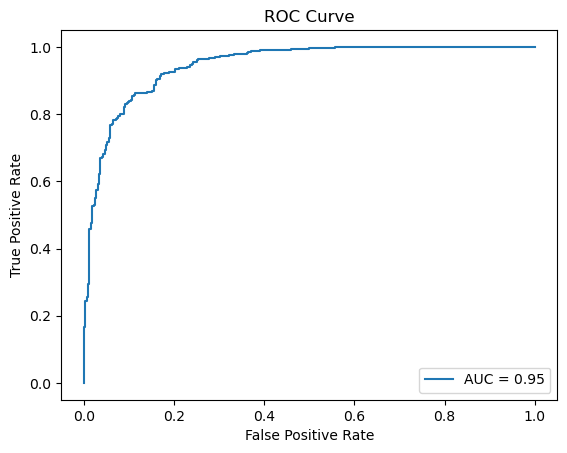

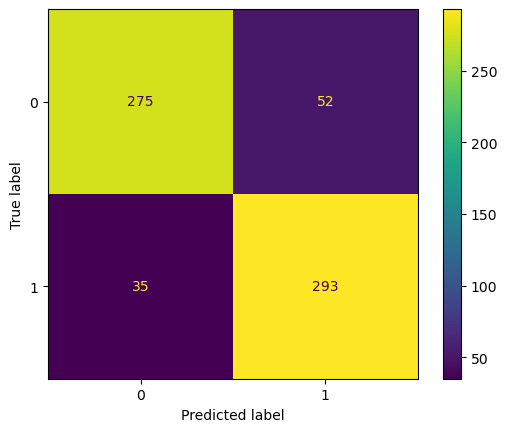

Test loss: 0.3044655919075012
Test Accuracy 0.8671755790710449


In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

loss, accuracy = model.evaluate(X_val, y_val)

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_val)) == 2:
    auc = roc_auc_score(y_val, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')

In [10]:
model.classifier.save(filepath="../Models/AE_Classifier_larger.keras")